<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/Project_2%2C_Human_Interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph requests

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
LANGCHAIN_API_KEY = userdata.get('Langchain_api_key')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)
llm.invoke("assalamualyum , i m hafiz naveed uddin , how r u?")


AIMessage(content="Assalamu alaykum Hafiz Naveed Uddin! I hope you are well.  As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-53630662-19f7-4e40-a9ff-ce072c26f86e-0', usage_metadata={'input_tokens': 19, 'output_tokens': 59, 'total_tokens': 78, 'input_token_details': {'cache_read': 0}})

In [ ]:
from langchain_core.tools import Tool
# Define product database
products = {
    "P101": {"name": "Laptop", "price": 10600.0, "stock": 5, "description": "High-performance laptop", "reviews": ["Good quality", "Worth the price"]},
    "P102": {"name": "Smartphone", "price": 7500.0, "stock": 0, "description": "Latest model smartphone", "reviews": ["Battery life is short", "Excellent camera"]},
    "P103": {"name": "Headphones", "price": 500.0, "stock": 15, "description": "Noise-cancelling headphones", "reviews": ["Great sound quality"]},
}

# Tool 1: Product Details
def get_product_details(product_id: str) -> str:
    """Fetch product details."""
    product = products.get(product_id)
    if not product:
        return f"Product with ID {product_id} not found."
    return (
        f"Product: {product['name']}\n"
        f"Price: ${product['price']}\n"
        f"Stock: {product['stock']} units\n"
        f"Description: {product['description']}\n"
        f"Reviews: {', '.join(product['reviews'])}"
    )

# Tool 2: Stock Management
def update_stock(product_id: str, new_stock: int) -> str:
    """Update product stock."""
    product = products.get(product_id)
    if not product:
        return f"Product with ID {product_id} not found."
    product["stock"] = new_stock
    return f"Stock updated for {product['name']}: {new_stock} units available."

# Tool 3: Shipping Cost Estimate
def calculate_shipping_cost(distance: float, weight: float) -> float:
    """Calculate shipping cost based on distance and weight."""
    base_rate = 5.0  # $5 per km per kg
    return distance * weight * base_rate

# Tool 4: Order Tracking
def track_order(order_id: str) -> str:
    """Track order status."""
    orders = {"O001": "Processing", "O002": "Shipped", "O003": "Delivered"}
    status = orders.get(order_id)
    return f"Order ID {order_id} is {status}" if status else f"Order ID {order_id} not found."

# Tool 5: Manage Reviews
def add_review(product_id: str, review: str) -> str:
    """Add a review for a product."""
    product = products.get(product_id)
    if not product:
        return f"Product with ID {product_id} not found."
    product["reviews"].append(review)
    return f"Review added for {product['name']}: {review}"

# Tool Registration
tools = [
    Tool(name="get_product_details", func=get_product_details, description="Fetch product details."), # Changed tool name
    Tool(name="update_stock", func=update_stock, description="Update stock for a product."), # Changed tool name
    Tool(name="calculate_shipping_cost", func=calculate_shipping_cost, description="Estimate delivery charges."), # Changed tool name
    Tool(name="track_order", func=track_order, description="Check order delivery status."), # Changed tool name
    Tool(name="add_review", func=add_review, description="Add a product review."), # Changed tool name
]

# Bind tools to AI agent

llm_with_tools = llm.bind_tools(tools)

In [ ]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7b1ef38ab130>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_product_details', 'description': 'Fetch product details.', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'update_stock', 'description': 'Update stock for a product.', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'calculate_shipping_cost', 'description': 'Estimate delivery charges.', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'fun

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()

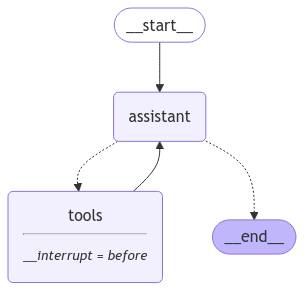

In [ ]:
sys_msg = SystemMessage(content="You are a smart E-commerce assistant tasked with helping customers and sellers by providing product details, managing inventory, calculating shipping costs, tracking orders, and recommending products.")
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {'configurable': {"thread_id": "1"}}
msg = graph.invoke({"messages": [HumanMessage(content="Show me the details of product P101")]}, config)
for m in msg["messages"]:
    m.pretty_print()


================================ Human Message =================================

Show me the details of product P101
================================== Ai Message ==================================
Tool Calls:
  get_product_details (8bf8da3e-2a57-40b9-be9b-0c36d7b72e94)
 Call ID: 8bf8da3e-2a57-40b9-be9b-0c36d7b72e94
  Args:
    __arg1: P101


In [ ]:
state = graph.get_state(config)
state.next

('tools',)

In [ ]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_product_details (8bf8da3e-2a57-40b9-be9b-0c36d7b72e94)
 Call ID: 8bf8da3e-2a57-40b9-be9b-0c36d7b72e94
  Args:
    __arg1: P101
================================= Tool Message =================================
Name: get_product_details

Product: Laptop
Price: $10600.0
Stock: 5 units
Description: High-performance laptop
Reviews: Good quality, Worth the price
================================== Ai Message ==================================

Product: Laptop
Price: $10600.0
Stock: 5 units
Description: High-performance laptop
Reviews: Good quality, Worth the price


In [ ]:
config = {'configurable': {"thread_id": "2" }}
msg = graph.invoke({"messages": [HumanMessage(content="Show me the details of product P101")]},config)
for m in msg["messages"]:
  m.pretty_print()
# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":

    # If approved, continue the graph execution
    for event in graph.stream(None, config, stream_mode="values"):
        event['messages'][-1].pretty_print()

else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Show me the details of product P101
================================== Ai Message ==================================
Tool Calls:
  get_product_details (dd26d4a0-1bad-4c0e-9632-56b259f394ae)
 Call ID: dd26d4a0-1bad-4c0e-9632-56b259f394ae
  Args:
    __arg1: P101
Do you want to call the tool? (yes/no): yes
================================== Ai Message ==================================
Tool Calls:
  get_product_details (dd26d4a0-1bad-4c0e-9632-56b259f394ae)
 Call ID: dd26d4a0-1bad-4c0e-9632-56b259f394ae
  Args:
    __arg1: P101
================================= Tool Message =================================
Name: get_product_details

Product: Laptop
Price: $10600.0
Stock: 5 units
Description: High-performance laptop
Reviews: Good quality, Worth the price
================================== Ai Message ==================================

Product: Laptop
Price: $10600.0
Stock: 5 units
Description: High-performa

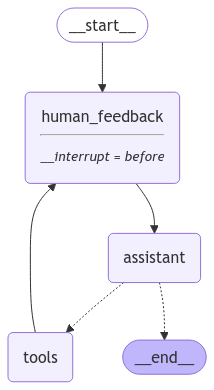

In [ ]:
sys_msg = SystemMessage(content="You are a smart E-commerce assistant tasked with helping customers and sellers by providing product details, managing inventory, calculating shipping costs, tracking orders, and recommending products.")

def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
config = {'configurable': {"thread_id": "3" }}
msg = graph.invoke({"messages": [HumanMessage(content="Show me the details of product P101")]},config)
for m in msg["messages"]:
  m.pretty_print()
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(config, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Show me the details of product P101
Tell me how you want to update the state: This product is not available
================================ Human Message =================================

This product is not available
================================== Ai Message ==================================

Could you please specify which product you're inquiring about?  I need a product ID or name to check its availability and details.


In [ ]:
config = {'configurable': {"thread_id": "4" }}
msg = graph.invoke({"messages": [HumanMessage(content="Show me the details of product P101")]},config)
for m in msg["messages"]:
  m.pretty_print()
# Get user input
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":

    # If approved, continue the graph execution
    for event in graph.stream(None, config, stream_mode="values"):
        event['messages'][-1].pretty_print()

else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Show me the details of product P101
Do you want to call the tool? (yes/no): no
Operation cancelled by user.


# ***REMARKS ***
I have learned from the human feedback nodes how a chatbot and a human connect with each other. Here, I understood how the chatbot clarifies with a human when it doesn’t understand something. I also learned how to interrupt tools and humans effectively. However, I couldn’t implement long-term memory because it was causing some issues alongside interruptions.